# Import/Initialize

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from tqdm import tqdm

import time
from PIL import Image
import cv2
from skimage.color import rgba2rgb
from skimage.io import imread
import copy

from collections import OrderedDict

In [2]:
CHANNEL_N = 16
RADIUS = 1
NUM_FILTERS = 6
HIDDEN_N = 128
# HIDDEN_N = [128, CHANNEL_N]

EMBED_KERNEL = 5

TARGET_SIZE = 40
TARGET_PADDING = 16
BATCH_SIZE = 1

In [3]:
class Filter(nn.Module):
    def __init__(self, r=RADIUS, symmetric=True):
        super().__init__()
        
        
        f = torch.randn(2*r + 1)
        if symmetric:
            f = (f + f.flip(0))/2
        f = torch.ger(f, f)
#         f[r, r] = 0
        f = f - f.mean()
#         f = f - f.sum()/(f.numel() - 1)

#         f[r, r] = 0
#         f = f / (f.numel() - 1)
        
        f = f / (f.numel())
        
        self.kernel = nn.Parameter(f)


class CAModel(nn.Module):
    def __init__(self, channel_n=CHANNEL_N, r=RADIUS, num_filters=NUM_FILTERS, hidden_n=HIDDEN_N):
        super().__init__()            
        
        self.channel_n = channel_n
        self.r = r
        self.num_filters = num_filters
        self.fire_rate = 0.5
        
        # define identity matrix
        identity = torch.zeros(2*self.r + 1)
        identity[self.r] = 1
        self.identity = torch.ger(identity, identity)
        self.identity = nn.Parameter(self.identity, requires_grad=False)

        # initialize perception kernel (trainable) 
        self.rand_filters = [Filter(self.r, symmetric=True).kernel for i in range(self.num_filters)]
        
        self.filters = nn.ParameterList([self.identity] + self.rand_filters)
        
        # Sobel filters
#         self.sx = torch.ger(torch.FloatTensor([1, 2, 1]), torch.FloatTensor([-1, 0, 1])) / 8
#         self.sx = nn.Parameter(self.sx, requires_grad=False)
#         self.sy = nn.Parameter(self.sx.T.type(torch.FloatTensor), requires_grad=False)
#         self.filters = [torch.cuda.FloatTensor(self.sx), torch.cuda.FloatTensor(self.sy)]
        
        
        # 1D conv network
        self.dmodel = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(self.channel_n*(self.num_filters + 1), hidden_n, 1, padding_mode='circular')),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(hidden_n, self.channel_n, 1, padding_mode='circular')),
        ]))
        
        # 1D conv network
#         self.dmodel = [nn.Conv2d(self.channel_n*(self.num_filters + 1), hidden_n[0], 1, padding_mode='circular')]
#         self.dmodel.append(nn.LeakyReLU())
#         for i in range(1, len(hidden_n)):
#             l = nn.Conv2d(hidden_n[i-1], hidden_n[i], 1, padding_mode='circular')
#             self.dmodel.append(l)
#             if i < (len(hidden_n) - 1):
#                 self.dmodel.append(nn.LeakyReLU())
        
        gain=nn.init.calculate_gain('leaky_relu')
#         for l in self.dmodel:
#             if type(l) == nn.Conv2d:
#                 nn.init.xavier_uniform_(l.weight, gain)
#         self.dmodel = nn.Sequential(*self.dmodel)
        
        # update rule - initialized with zeros so initial behaviour is 'do nothing' (trainable)
#         gain=nn.init.calculate_gain('relu')
#         nn.init.zeros_(self.dmodel.conv2.weight)
#         nn.init.zeros_(self.dmodel.conv2.bias)

        nn.init.xavier_uniform_(self.dmodel.conv1.weight, gain)
#         nn.init.zeros_(self.dmodel.conv2.bias)

        nn.init.xavier_uniform_(self.dmodel.conv2.weight, gain)

         
    def perceive(self, x):              
#         filters = [self.identity] + [f.kernel for f in self.rand_filters]
#         filters = [self.identity, self.sx, self.sy]
        filters = [f for f in self.filters]
        numFilters = len(filters)
        k_size = 2*self.r + 1
        
        filters = torch.stack(filters).unsqueeze(0)
        filters = torch.repeat_interleave(filters, self.channel_n, dim=0)
        filters = filters.view(self.channel_n*numFilters, 1, k_size, k_size)  # combine filters into batch dimension (or out dimension, idk)
        
        # depthwise conv2d (groups==self.channel_n)
        x = F.pad(x, (self.r, self.r, self.r, self.r), mode='circular')
        y = F.conv2d(x, filters, padding=self.r, groups=self.channel_n) 
        y = y[:, :, self.r:-self.r, self.r:-self.r]
        return y
    
    def get_living_mask(self, x):
        alpha_channel = x[:, 3:4, :, :]
        alpha_channel = F.pad(alpha_channel, (self.r, self.r, self.r, self.r), mode='circular')

        alive_mask = F.max_pool2d(alpha_channel, kernel_size=2*self.r+1, stride=1, padding=self.r) > 0.1
        alive_mask = alive_mask[:, :, self.r:-self.r, self.r:-self.r] 
        
        death_mask = F.avg_pool2d(alpha_channel, kernel_size=2*self.r+1, stride=1, padding=self.r) < 0.2
        death_mask = death_mask[:, :, self.r:-self.r, self.r:-self.r] 
        return alive_mask.cuda() & death_mask.cuda()
    
    def forward(self, x, fire_rate=None, step_size=1.0):
        
        pre_life_mask = self.get_living_mask(x)
        
        y = self.perceive(x)
        dx = self.dmodel(y) * step_size 
        
        if fire_rate is None:
            fire_rate = self.fire_rate
        update_mask = (torch.rand(x[:, :1, :, :].shape) <= fire_rate).type(torch.FloatTensor).cuda()
        x = x + dx * update_mask
        
        post_life_mask = self.get_living_mask(x)
        life_mask = (pre_life_mask & post_life_mask).type(torch.FloatTensor).cuda()
        
        x = x * life_mask
 
        return x

def to_rgba(x):
    return x[:, :4, :, :]

def to_alpha(x):
    return np.clip(x[:, 3:4, :, :], 0.0, 1.0)

def to_rgb(x):
    # assume rgb premultiplied by alpha
    rgb, a = x[:, :3, :, :], to_alpha(x)
    return 1.0-a+rgb

def load_image(fname, max_size=TARGET_SIZE):
    img = Image.open(fname)
    img.thumbnail((max_size, max_size), Image.ANTIALIAS)
    img = np.float32(img)/255.0
    # premultiply RGB by Alpha
    img[..., :3] *= img[..., 3:]
    return img

In [18]:
class Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.c1 = nn.Conv2d(4, 32, EMBED_KERNEL, padding=EMBED_KERNEL-1, padding_mode='circular')
        self.c2 = nn.Conv2d(32, 32, EMBED_KERNEL, padding=EMBED_KERNEL-1, padding_mode='circular')
        mp_kernel = 5  # SIZE / (mp_kernel*2) / mp_kernal = 1
        self.mp1 = nn.MaxPool2d(2*mp_kernel, stride=2*mp_kernel)
        
        self.c3 = nn.Conv2d(32, 32, EMBED_KERNEL, padding=EMBED_KERNEL-1, padding_mode='circular')
        self.c4 = nn.Conv2d(32, 8, EMBED_KERNEL, padding=EMBED_KERNEL-1, padding_mode='circular')
        self.mp2 = nn.MaxPool2d(mp_kernel, stride=mp_kernel)
        
        # average pooling
        
    def forward(self, x):
        z = F.leaky_relu(self.c1(x))
        z = F.leaky_relu(self.c2(z))
        z = self.mp1(z)
        
        z = F.leaky_relu(self.c3(z))
        z = self.c4(z)
        z = self.mp2(z)
        
        return z

In [5]:
SIZE = 50

x = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, SIZE, SIZE))).unsqueeze(0) > 3
x = x.type(torch.cuda.FloatTensor)

In [20]:
embed = Embedder().cuda()

In [21]:
embed(x[:, 0:4, :, :]).shape

torch.Size([1, 8, 1, 1])

# Run for fun (remove zero weight initialization on final layer)

In [134]:
CA_run = CAModel()

if torch.cuda.is_available():
    CA_run.cuda()

0


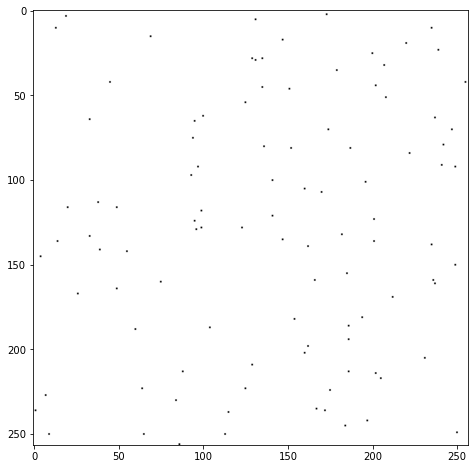

KeyboardInterrupt: 

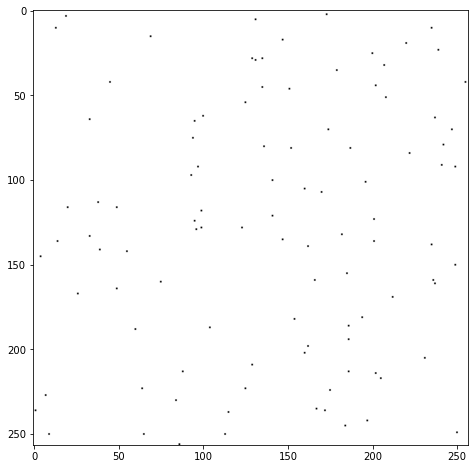

In [7]:
SIZE = 257

x = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, SIZE, SIZE))).unsqueeze(0) > 3
x = x.type(torch.cuda.FloatTensor)
# x = torch.cuda.FloatTensor(np.zeros((CHANNEL_N, SIZE, SIZE))).unsqueeze(0)
# x[:, 3:, SIZE//2, SIZE//2] = 1
# x[:, 3:, 256//3 : 2*256//3, 256//3 : 2*256//3] = 1

# x[:, 3:, SIZE//3, SIZE//3] = 1
# x[:, 3:, 2*SIZE//3, 2*SIZE//3] = 1

imgs = []

timeSteps = 500
for i in range(timeSteps):
#     print(i, stop)
    nx = x.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
    nx = rgba2rgb(nx)
    imgs.append(nx)
    
    if i%50 == 0:
        plt.clf()
        plt.imshow(nx)
        plt.gcf().set_size_inches((8,8))
        clear_output(wait=True)
        print(f'{i}')
        display(plt.gcf())
        time.sleep(0.01)

    x = torch.tanh(CA_run.forward(x, step_size=1, fire_rate=1))
    x = x.detach()
    

fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (SIZE, SIZE), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

In [363]:
fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 150, (SIZE, SIZE), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

# Train

In [42]:
seed = 10000
np.random.seed(seed)
torch.manual_seed(seed)

NUM_POP = 15

CA_orig = CAModel()

CAs = [CA_orig]
for i in range(NUM_POP - 1):
    CAs.append(copy.deepcopy(CA_orig))

CA = CAModel()
embed = Embedder().cuda()
if torch.cuda.is_available():
    for CA in CAs:
        CA.cuda()
        
    embed.cuda()

In [43]:
optim_emb = torch.optim.Adam([p for p in embed.parameters()], lr=1e-3)
Optims_CAs = [torch.optim.Adam([p for p in CA.parameters()], lr=1e-3) for CA in CAs]

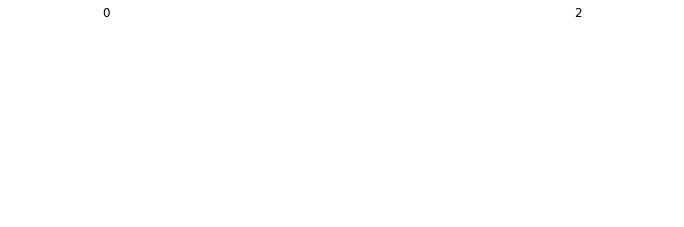

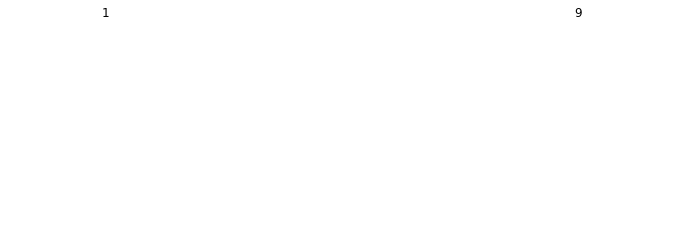

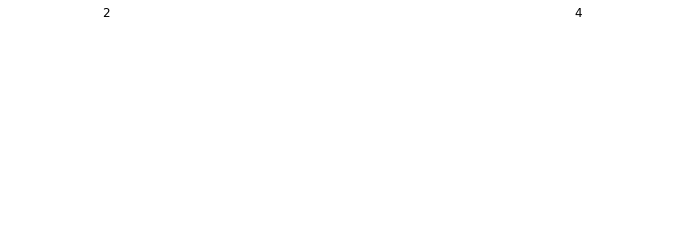

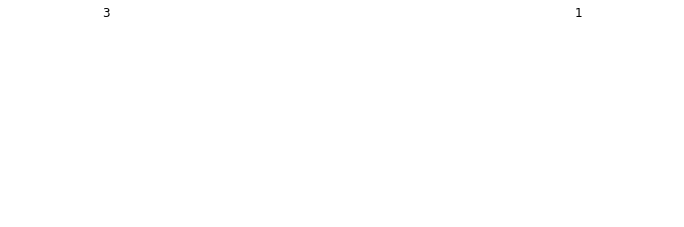

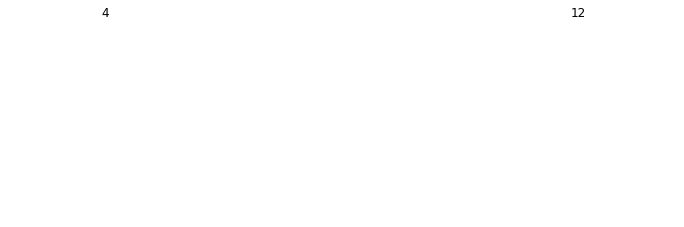

KeyboardInterrupt: 

In [45]:
res = 50
step_size = 1
fire_rate = 1

emb_loss = []
tloss = nn.TripletMarginLoss()
epochs = 100

index_list = np.arange(len(CAs))

for epoch in tqdm(range(epochs)):
    
    clear_output(wait=True)
    
    optim_emb.zero_grad()
    for optim_CA in Optims_CAs:
        optim_CA.zero_grad()
    total_loss = 0
    
    for CA_i, CA_A in enumerate(CAs):
        # pick random other CA
        rand_index = np.random.permutation(index_list[index_list != CA_i])[0]

        CA_B = CAs[rand_index]
        
        # reset IC
        x_A1 = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, res, res))).unsqueeze(0)
        x_A2 = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, res, res))).unsqueeze(0)
        x_B = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, res, res))).unsqueeze(0)
        
        # single seed IC
#         x_A1 = torch.cuda.FloatTensor(np.zeros((CHANNEL_N, res, res))).unsqueeze(0)
#         x_A1[:, 3:, res//2, res//2] = 1
        
#         x_A2 = torch.cuda.FloatTensor(np.zeros((CHANNEL_N, res, res))).unsqueeze(0)
#         x_A2[:, 3:, res//2, res//2] = 1
        
#         x_B = torch.cuda.FloatTensor(np.zeros((CHANNEL_N, res, res))).unsqueeze(0)
#         x_B[:, 3:, res//2, res//2] = 1

        # let the CAs reach some equilibrium point
#         for ii in range(200):
#             x_A1 = torch.tanh(CA_A.forward(x_A1, step_size=step_size, fire_rate=fire_rate)).detach()
#             x_A2 = torch.tanh(CA_A.forward(x_A2, step_size=step_size, fire_rate=fire_rate)).detach()
#             x_B = torch.tanh(CA_B.forward(x_B, step_size=step_size, fire_rate=fire_rate)).detach()
    
        
        for jj in range(1):
            
            # forward, save in memory
            z_A1 = []
            z_A2 = []
            z_B = []
            
            for ii in range(40):
                # check gradients
                x_A1 = torch.tanh(CA_A.forward(x_A1, step_size=step_size, fire_rate=fire_rate))
                x_A2 = torch.tanh(CA_A.forward(x_A2, step_size=step_size, fire_rate=fire_rate))
                x_B = torch.tanh(CA_B.forward(x_B, step_size=step_size, fire_rate=fire_rate))

                if ii%5==0:
                    # embed, calculate loss
                    z_A1.append(embed.forward(x_A1[:, 0:4, :, :]))
                    z_A2.append(embed.forward(x_A2[:, 0:4, :, :]))
                    z_B.append(embed.forward(x_B[:, 0:4, :, :]))

            z_A1 = torch.cat(z_A1, 0)
            z_A2 = torch.cat(z_A2, 0)
            z_B = torch.cat(z_B, 0)

            loss = tloss(z_A1,z_A2,z_B)
            total_loss += loss.cpu().detach().item()
            loss.backward()

            x_A1 = x_A1.detach()
            x_A2 = x_A2.detach()
            x_B = x_B.detach()
            
        ##### PLOTTING THINGS #####
        nx_A1 = x_A1.cpu().detach().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx_A1 = rgba2rgb(nx_A1)
        nx_A1 = np.uint8(nx_A1*255.0)
        
        nx_A2 = x_A2.cpu().detach().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx_A2 = rgba2rgb(nx_A2)
        nx_A2 = np.uint8(nx_A2*255.0)
        
        nx_B = x_B.cpu().detach().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx_B = rgba2rgb(nx_B)
        nx_B = np.uint8(nx_B*255.0)

        fig, axes = plt.subplots(1, 3, figsize=(12, 6))
        
        axes[0].imshow(nx_A1)
        axes[0].set_title(f'{CA_i}')
        axes[1].imshow(nx_A2)
        axes[2].imshow(nx_B)
        axes[2].set_title(f'{rand_index}')
        
        for ax in axes:
            ax.set_axis_off()
        
#         fig.canvas.draw()
        plt.show()
        ###########################

    # normalize gradients
    for CA in CAs:
        for p in CA.parameters():
            if p.grad is not None:
                p.grad = p.grad / (1e-8 + torch.norm(p.grad))
            
    emb_loss.append(total_loss)
    optim_emb.step()
    for optim_CA in Optims_CAs:
        optim_CA.step()
    print(f't={epoch}, loss_emb={emb_loss[-1]:.4f}')




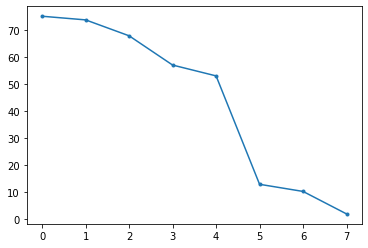

In [31]:
plt.plot(emb_loss, '.-')

In [357]:
for i in range(0, BATCH_SIZE):
    ex_img = np.array(imgs)[:, i, :, :, :]

    fname = time.strftime("%Y%m%d-%H%M%S") + f'_{i}'
    out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, (h, w), 3)

    for img in ex_img[:]:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        out.write(img)
    out.release()

# Run Trained Model

In [46]:
CA = CAs[5]

550


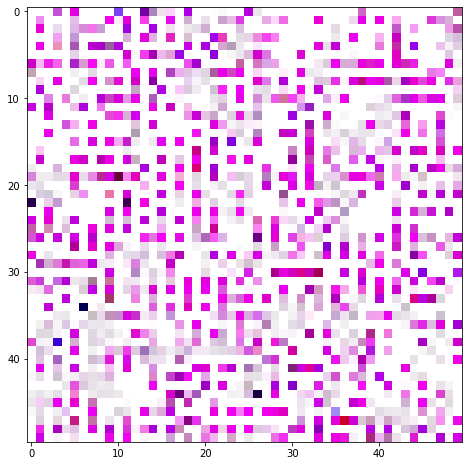

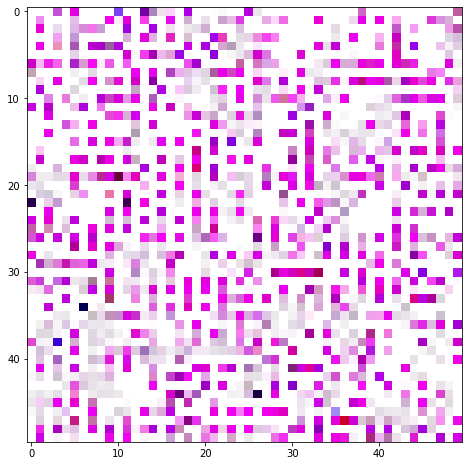

In [55]:
SIZE = 50
# x = torch.cuda.FloatTensor(np.random.standard_normal(size=(CHANNEL_N, SIZE, SIZE))).unsqueeze(0) 
x = torch.cuda.FloatTensor(np.zeros((CHANNEL_N, SIZE, SIZE))).unsqueeze(0)
# x[:, 3:, SIZE//2, SIZE//2] = 1
# x[:, 3:, SIZE//3:2*SIZE//3, SIZE//3:2*SIZE//3] = 1
x[:, 3:, SIZE//3:2*SIZE//3, SIZE//3:2*SIZE//3] = torch.cuda.FloatTensor(np.random.standard_normal(size=(13, SIZE//3+1, SIZE//3+1))).unsqueeze(0) 
imgs = []

for i in range(600):
    
    with torch.no_grad():
        nx = x.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx = rgba2rgb(nx)
    #     nx = np.uint8(nx*255.0)
        imgs.append(nx)

        x = torch.tanh(CA.forward(x, step_size=1, fire_rate=1))
        x = x.detach()


        if i%50 == 0:
            plt.clf()
            plt.imshow(nx)
            plt.gcf().set_size_inches((8,8))
            clear_output(wait=True)
            print(f'{i}')
            display(plt.gcf())
            time.sleep(0.01)


            
fname = time.strftime("%Y%m%d-%H%M%S")

out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'mp4v'), 30, (SIZE, SIZE), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

In [48]:
import imageio
from os import path, makedirs

folder = 'png_seq/' + fname
if not path.exists(folder):
    makedirs(folder)
            
imgs = [np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0) for img in imgs]
for i, img in enumerate(imgs):
    imageio.imwrite(folder + f'/_{str(i).zfill(3)}.png', img, format='png')

In [47]:
folder

'png_seq/20200416-045015'

In [44]:
for img in imgs:
    imageio.imwrite(fname + '.png', img, format='png')

In [32]:
fname = 'model/CA_model_' + time.strftime("%Y%m%d-%H%M%S") + '.pb'
torch.save(CA.dmodel, fname)

In [30]:
CA = CAModel()

CA.dmodel = torch.load(fname)
CA.cuda()

CAModel(
  (dmodel): Sequential(
    (conv1): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
  )
)